# Final Report_v3

* Author : 楊右宇  
* Establish Date：2021.01.09  
* Last Modified Date：2021.01.16

In [159]:
# %pip install yfinance

# import library

In [130]:
import pandas as pd
import numpy as np
import math
import mplfinance as mpf
import yfinance as y

# Indicators

## Moving Average
* 均線

In [131]:
def MA(_ticker, period=10, field='Close'):

    '''可以自訂要幾日均線，也可以計算成交量等數值的均線'''
    
    # 複製一份資料，避免修改原始資料
    res = _ticker.copy(deep=True)
    
    if field == 'Volume':
        res['VMA_' + str(period)] = _ticker[field].rolling(period).mean()

    else:
        res['MA_' + str(period)] = _ticker[field].rolling(period).mean()

    return res

## EMA

In [132]:
def EMA(_ticker, period=15):
    
    '''計算EMA，並新增在 DataFrame 中，數值為指數衰減'''

    # 複製一份資料，避免修改原始資料
    res = _ticker.copy(deep=True)
    
    # 新增新的一欄在 DataFrame 中
    res['EMA_' + str(period)] = _ticker['Close'].ewm(span=period, adjust=False).mean()

    return res

## RSI

* Relative Strength Index
* 相對強弱指標
* 計算出一個 0 ~ 100 之間的數字
* 越接近 0 表示盤勢越弱
* 越接近 100 表示盤勢越強

In [133]:
def RSI(_ticker, period = 14):
    
    # 創建暫存資料
    tmp = pd.DataFrame(index=_ticker.index)

    # 複製一份資料，避免修改原始資料
    res = _ticker.copy(deep=True)
    
    # 新增新資料欄位，預設為空
    tmp['rise'] = np.nan

    # 搜尋特定欄位之 index
    col_rise = tmp.columns.get_loc('rise')
    col_close = _ticker.columns.get_loc('Close')

    # 計算今日漲跌數字
    for i in range(1, len(_ticker)):
        tmp.iloc[i, col_rise] = (_ticker.iloc[i, col_close] - _ticker.iloc[i - 1, col_close])

    # 創建空資料欄
    tmp['rise_only'] = tmp['rise']
    tmp['drop_only'] = tmp['rise']

    # 依照數值大小於零分堆
    tmp['rise_only'].loc[tmp['rise'] < 0] = 0
    tmp['drop_only'].loc[tmp['rise'] > 0] = 0
    
    # 計算 N 天內平均漲跌數值
    tmp['rise_avg'] = tmp['rise_only'].rolling(period).mean()
    tmp['drop_avg'] = tmp['drop_only'].rolling(period).mean().abs()

    # 計算 RSI
    res['RSI'] = tmp['rise_avg'] / (tmp['rise_avg'] + tmp['drop_avg']) * 100
    
    return res

## KD

* Ｋ值比Ｄ值敏感，波動幅度較大
* Ｋ值線如果在低檔區由下而上穿過Ｄ值線，稱作黃金交叉，代表接下來盤勢上漲機會大
* Ｋ值線如果在高檔區由上而下穿過Ｄ值線，稱作死亡交叉，代表接下來盤勢下跌機會大

In [134]:
def KD(_ticker, period = 9):

    # 創建暫存資料
    tmp = pd.DataFrame(index=_ticker.index)

    # 複製一份資料，避免修改原始資料
    res = _ticker.copy(deep=True)

    # 尋找 N 日內最高最低價
    tmp['max_close'] = ticker['Close'].rolling(period, min_periods=1).max()
    tmp['min_close'] = ticker['Close'].rolling(period, min_periods=1).min()

    # 計算 RSI
    tmp['RSV'] = (ticker['Close'] - tmp['min_close']) / (tmp['max_close'] - tmp['min_close']) * 100

    # 由於 K D 之定義為遞迴式，且數值為 0 ~ 100，預設為 50
    res['K'] = 50
    res['D'] = 50
    
    # 搜尋特定欄位之 index
    col_k = res.columns.get_loc('K')
    col_d = res.columns.get_loc('D')
    col_rsv = tmp.columns.get_loc('RSV')

    # 計算 K 與 D 值
    for i in range(1, len(_ticker)):
        res.iloc[i, col_k] = res.iloc[i - 1, col_k] * 2 / 3 + tmp.iloc[i, col_rsv] * 1 / 3
        res.iloc[i, col_d] = res.iloc[i - 1, col_d] * 2 / 3 + res.iloc[i, col_k] * 1 / 3
    
    return res

## MACD

* macd（對應diff）
* macdsignal（對應dea）
* macdhist（對應macd）

### 簡易策略
* DIFF、DEA均為正，DIFF向上突破DEA，買入信號。

* DIFF、DEA均為負，DIFF向下跌破DEA，賣出信號。

* DEA線與K線發生背離，行情反轉信號。

* 分析MACD柱狀線，由正變負，賣出信號；由負變正，買入信號。

In [135]:
def MACD(_ticker, fast_period=12, slow_period=26, signal_period=9):
    
    # 複製一份資料，避免修改原始資料
    res = _ticker.copy(deep=True)

    # 計算快慢 EMA
    ema_f = _ticker['Close'].ewm(span=fast_period, adjust=False).mean()
    ema_s = _ticker['Close'].ewm(span=slow_period, adjust=False).mean()
    
    # 計算 MACD 值
    res['macd_dif'] = ema_f - ema_s
    res['macd_dea'] = res['macd_dif'].ewm(span=signal_period, adjust=False).mean()
    res['macd'] = res['macd_dif'] - res['macd_dea']

    return res

## Bollinger Bands

In [136]:
def BBands(_ticker, period=20, std_num=2):
    
    # 複製一份資料，避免修改原始資料
    res = _ticker.copy(deep=True)

    # 計算中線，也就是二十日 MA
    res['bbands_middle'] = _ticker['Close'].rolling(period).mean()
    
    # 計算標準差
    std = _ticker['Close'].rolling(period).std(ddof=0) 
    
    # 計算上下軌
    res['bbands_upper'] = res['bbands_middle'] + std * std_num 
    res['bbands_lower'] = res['bbands_middle'] - std * std_num

    return res

# 交易策略

## KD + RSI
* 多 : KD 黃金交叉，且 RSI 也大於某一數值
* 空 : KD 死亡交叉，且 RSI 也小於某一數值
* 因為 KD 指標較敏感，交叉次數太多，所以藉由 RSI 去確認是否會太弱

In [137]:
def kd_rsi_rule(_ticker, buy_point_name='buy_point', rsi_period=14, kd_period=9, 
        rsi_buy_point=35, rsi_sell_point=65):
    
    # 複製一份資料，避免修改原始資料
    res = _ticker.copy(deep=True)
    
    # 檢查指標是否存在
    try:
        if not {'K', 'D'}.issubset(res.columns):
            res = KD(res, kd_period)
        if not {'RSI'}.issubset(res.columns):
            res = RSI(res, rsi_period)
    except Exception as e:
        print(e)
        return False
    
    # 新增一個空行，預設值為零
    res[buy_point_name] = 0

    # 取得 index 值，方便計算使用
    t = res.index

    for i in range(1, len(res)):
        if res.loc[t[i], 'K'] > res.loc[t[i], 'D'] \
                and res.loc[t[i - 1], 'K'] < res.loc[t[i - 1], 'D'] \
                and res.loc[t[i], 'RSI'] > rsi_buy_point:

            res.loc[t[i], 'buy_point'] = 1
        
        elif res.loc[t[i], 'K'] < res.loc[t[i], 'D'] \
                and res.loc[t[i - 1], 'K'] > res.loc[t[i - 1], 'D'] \
                and res.loc[t[i], 'RSI'] < rsi_sell_point:

            res.loc[t[i], 'buy_point'] = -1

    return res

## BBands + EMA

* 買 : 布林帶撞破下軌後，站回均線，或是布林通道三軌同時上揚
* 賣 : 布林帶撞破上軌後，跌破均線，或是布林帶收縮時

In [138]:
def bbands_ema_rule(_ticker, buy_point_name='buy_point', 
        bb_period=20, bb_stdnum=2, ma_period=5):
    
    # 複製一份資料，避免修改原始資料
    res = _ticker.copy(deep=True)

    # 檢查使否存在要用的指標
    try:
        if not {'bbands_middle', 'bbands_upper', 'bbands_lower'}.issubset(res.columns):
            res = BBands(res, bb_period, bb_stdnum)
        if not {'EMA_' + str(ma_period)}.issubset(res.columns):
            res = EMA(res, ma_period)
    except Exception as e:
        print(e)
        return False

    # 新增一個空行，預設值為零
    res[buy_point_name] = 0

    # 取得 index 值，方便計算使用
    t = res.index

    # 判斷前幾日始否跌破下軌了
    is_lower = False
    is_upper = False

    for i in range(1, len(res)):

        # 計算是否符合做多首要條件
        if res.loc[t[i], 'Close'] < res.loc[t[i], 'bbands_lower']:
            is_lower = True
        elif res.loc[t[i], 'Close'] > res.loc[t[i], 'bbands_middle']:
            is_lower = False

        # 計算是否符合做空首要條件
        if res.loc[t[i], 'Close'] > res.loc[t[i], 'bbands_upper']:
            is_upper = True
        elif res.loc[t[i], 'Close'] < res.loc[t[i], 'bbands_middle']:
            is_upper = False
        
        # 計算做多點
        if is_lower and res.loc[t[i], 'Close'] > res.loc[t[i], 'EMA_' + str(ma_period)] \
                or res.loc[t[i], 'bbands_upper'] > res.loc[t[i - 1], 'bbands_upper'] \
                and res.loc[t[i], 'bbands_middle'] > res.loc[t[i - 1], 'bbands_middle'] \
                and res.loc[t[i], 'bbands_lower'] > res.loc[t[i - 1], 'bbands_lower']:
            
            res.loc[t[i], 'buy_point'] = 1
        
        # 計算做空點
        elif is_upper and res.loc[t[i], 'Close'] < res.loc[t[i], 'EMA_' + str(ma_period)] \
                or res.loc[t[i], 'bbands_upper'] < res.loc[t[i - 1], 'bbands_upper'] \
                and res.loc[t[i], 'bbands_lower'] > res.loc[t[i - 1], 'bbands_lower']:
            
            res.loc[t[i], 'buy_point'] = -1

    return res

## Bbands + EMA + RSI

In [139]:
def bbands_ema_rsi_rule(_ticker, buy_point_name='buy_point', 
        bb_fast=12, bb_slow=26, bb_period=9, rsi_period=14, 
        rsi_buy_point=40, rsi_sell_point=60, ma_period=5):
    
    # 複製一份資料，避免修改原始資料
    res = _ticker.copy(deep=True)

    # 檢查使否存在要用的指標
    try:
        if not {'bbands_middle', 'bbands_upper', 'bbands_lower'}.issubset(res.columns):
            res = BBands(res, bb_fast, bb_slow, bb_period)
        if not {'RSI'}.issubset(res.columns):
            res = RSI(res, rsi_period)
        if not {'EMA_' + str(ma_period)}.issubset(res.columns):
            res = EMA(res, ma_period)
    except Exception as e:
        print(e)
        return False

    res[buy_point_name] = 0
    t = res.index
    is_lower = False
    is_upper = False

    for i in range(1, len(res)):

        if res.loc[t[i], 'Close'] < res.loc[t[i], 'bbands_lower']:
            is_lower = True
        elif res.loc[t[i], 'Close'] > res.loc[t[i], 'bbands_middle']:
            is_lower = False
        
        if res.loc[t[i], 'Close'] > res.loc[t[i], 'bbands_upper']:
            is_upper = True
        elif res.loc[t[i], 'Close'] < res.loc[t[i], 'bbands_middle']:
            is_upper = False
        
        
        if is_lower and res.loc[t[i], 'Close'] > res.loc[t[i], 'EMA_' + str(ma_period)] \
            and res.loc[t[i], 'RSI'] < rsi_buy_point:
            
            res.loc[t[i], 'buy_point'] = 1
        
        elif is_upper and res.loc[t[i], 'Close'] < res.loc[t[i], 'EMA_' + str(ma_period)] \
            and res.loc[t[i], 'RSI'] > rsi_sell_point:
            
            res.loc[t[i], 'buy_point'] = -1

    return res

## MACD + 均線
* 多 : MACD 黃金交叉，且當日股價大於均線
* 空 : MACD 死亡交叉，且當日股價小於均線

In [140]:
def macd_ma_rule(_ticker, buy_point_name='buy_point', ma_period=5):
    
    # 複製一份資料，避免修改原始資料
    res = _ticker.copy(deep=True)

    # 檢查使否存在要用的指標
    try:
        if not {'macd_dif', 'macd_dea', 'macd'}.issubset(res.columns):
            res = MACD(res)
        if not {'MA_' + str(ma_period)}.issubset(res.columns):
            res = MA(res, ma_period)
    except Exception as e:
        print(e)
        return False

    # 新增一個空行，預設值為零
    res[buy_point_name] = 0

    # 取得 index 值，方便計算使用
    t = res.index

    # 計算是否符合多空點
    for i in range(0, len(_ticker)):
        
        if res.loc[t[i], 'macd'] > 0 and res.loc[t[i], 'Close'] > res.loc[t[i], 'MA_' + str(ma_period)]:

            res.loc[res.index[i], 'buy_point'] = 1

        elif res.loc[t[i], 'macd'] < 0 and res.loc[t[i], 'Close'] < res.loc[t[i], 'MA_' + str(ma_period)]:

            res.loc[res.index[i], 'buy_point'] = -1

    return res

##  均線
* 多 : 當日股價大於短期均線，且短期均線大於長期均線
* 空 : 當日股價小於均線均線，且短期均線小於長期均線

In [141]:
def ma_rule(_ticker, buy_point_name='buy_point', period_f=5, period_s=10):
    
    # 複製一份資料，避免修改原始資料
    res = _ticker.copy(deep=True)

    # 檢查使否存在要用的指標
    try:
        if not {'MA_' + str(period_f)}.issubset(res.columns):
            res = MA(res, period_f)
        if not {'MA_' + str(period_s)}.issubset(res.columns):
            res = MA(res, period_s)
    except Exception as e:
        print(e)
        return False

    # 新增一個空行，預設值為零
    res[buy_point_name] = 0

    # 取得 index 值，方便計算使用
    t = res.index

    # 計算是否符合多空點
    for i in range(0, len(_ticker)):
        
        if res.loc[t[i], 'Close'] > res.loc[t[i], 'MA_' + str(period_f)] \
                > res.loc[t[i], 'MA_' + str(period_s)]:

            res.loc[res.index[i], 'buy_point'] = 1

        elif res.loc[t[i], 'Close'] < res.loc[t[i], 'MA_' + str(period_f)] \
                < res.loc[t[i], 'MA_' + str(period_s)]:

            res.loc[res.index[i], 'buy_point'] = -1

    return res

## MACD

* 多 : MACD 黃金交叉
* 空 : MACD 死亡交叉

In [142]:
def macd_rule(_ticker, buy_point_name='buy_point'):
    
    # 複製一份資料，避免修改原始資料
    res = _ticker.copy(deep=True)

    # 檢查使否存在要用的指標
    try:
        if not {'macd_dif', 'macd_dea', 'macd'}.issubset(res.columns):
            res = MACD(res)
    except Exception as e:
        print(e)
        return False

    # 新增一個空行，預設值為零
    res[buy_point_name] = 0

    # 取得 index 值，方便計算使用
    t = res.index

    # 計算是否符合多空點
    for i in range(1, len(_ticker)):
        if res.loc[t[i], 'macd'] > 0 and res.loc[t[i - 1], 'macd'] < 0:

            res.loc[res.index[i], 'buy_point'] = 1

        elif res.loc[t[i], 'macd'] < 0 and res.loc[t[i - 1], 'macd'] > 0:

            res.loc[res.index[i], 'buy_point'] = -1

    return res

# 繪圖

## MUTI_PLOT

In [143]:
def plot_muti(_ticker, _title='', volume=True, buy_sell_point=False, 
    RSI=False, rsi_midline=False, rsi_bound=False, rsi_upper_bound=85, rsi_lower_bound=15, 
    KD=False, kd_bound=False, kd_upper_bound=85, kd_lower_bound=15, 
    MACD=False, BBands=False):

    apds = []
    _panel = 1

    # 繪製買賣點，並判斷繪圖範圍內是否存在買賣點，避免出錯
    if buy_sell_point:
        
        buy, sell = [np.nan], [np.nan]
        buy_b = False
        sell_b = False

        # 設定買賣點位，且避免遮擋到 K 線
        for i in range(1, len(_ticker)):

            if _ticker.loc[_ticker.index[i], 'ticker_num'] > _ticker.loc[_ticker.index[i - 1], 'ticker_num']:
                buy.append(_ticker.loc[_ticker.index[i], 'Low'] * 0.97)
                buy_b = True
            else:
                buy.append(np.nan)

            if _ticker.loc[_ticker.index[i], 'ticker_num'] < _ticker.loc[_ticker.index[i - 1], 'ticker_num']:
                sell.append(_ticker.loc[_ticker.index[i], 'High'] * 1.03)
                sell_b = True
            else:
                sell.append(np.nan)

        # 加入數據至圖中
        if buy_b:
            apds += [ 
            mpf.make_addplot(buy, panel=0, type = 'scatter', color = 'blue', marker = '^', markersize = 100)
            ]

        if sell_b:
            apds += [ 
                mpf.make_addplot(sell, panel=0, type = 'scatter', color = 'darkorange', marker = 'v', markersize = 100),
            ]

    # 加入 RSI 指標
    if RSI:

        _panel += 1
        apds += [ 
            mpf.make_addplot(_ticker['RSI'], panel = _panel - 1, color='#009393', ylabel='RSI', secondary_y=False)
        ]

        # 加入上下界線
        if rsi_bound:
            apds += [
                mpf.make_addplot(np.full((len(_ticker)), rsi_lower_bound), 
                    panel = _panel - 1, color='#F00078', alpha=0.5, secondary_y=False),
                mpf.make_addplot(np.full((len(_ticker)), rsi_upper_bound), 
                    panel = _panel - 1, color='#F00078', alpha=0.5, secondary_y=False)
            ]

        # 加入中線
        if rsi_midline:
            apds += [mpf.make_addplot(np.full((len(_ticker)), 50), 
                    panel = _panel - 1, color='#F00078', alpha=0.5)]

    # 加入 KD 指標
    if KD:

        _panel += 1
        apds += [ 
            mpf.make_addplot(_ticker['K'], panel=_panel - 1, color='#0000C6', 
                ylabel='KD'),
            mpf.make_addplot(_ticker['D'], panel=_panel - 1, color='#F75000'),
            ]

        # 加入上下界線
        if kd_bound:
            apds += [
                mpf.make_addplot(np.full((len(_ticker)), kd_upper_bound), 
                    panel=_panel - 1, color='#F00078', alpha=0.5, secondary_y=False),
                mpf.make_addplot(np.full((len(_ticker)), kd_lower_bound), 
                    panel=_panel - 1, color='#F00078', alpha=0.5, secondary_y=False)
            ]

    # 加入 MACD
    if MACD:

        _panel += 1
        apds += [
            mpf.make_addplot(_ticker['macd'], type='bar', ylabel='MACD', width=0.7, panel=_panel - 1,
                color='dimgray', alpha=1, secondary_y=False),
            mpf.make_addplot(_ticker['macd_dif'], panel=_panel - 1, color='fuchsia', secondary_y=True),
            mpf.make_addplot(_ticker['macd_dea'], panel=_panel - 1, color='b', secondary_y=True)
        ]

    # 如果要加成交量，層數加一
    if volume:
        _panel += 1

    # 加入布林帶
    if BBands:
        apds += [
            mpf.make_addplot(_ticker['bbands_middle'], panel=0, color='#9F4D95', alpha=1, width=1, secondary_y=False),
            mpf.make_addplot(_ticker['bbands_upper'], panel=0, color='black', alpha=0.5, width=0.8, secondary_y=False),
            mpf.make_addplot(_ticker['bbands_lower'], panel=0, color='black', alpha=0.5, width=0.8, secondary_y=False),
           
        ]

    # 設置k線圖顏色
    my_color = mpf.make_marketcolors(up='red',      # 上漲顏色
                                     down='green',  # 下跌顏色
                                     edge='i',      # 隱藏 K 線邊緣
                                     volume='in',   # 成交量用同樣的顏色
                                     inherit=True)  # 繼承其他參數

    # 設置圖型呈現
    my_style = mpf.make_mpf_style(gridaxis='both',          # 設置網格
                                  gridstyle='-.',           # 設定網格花樣
                                  y_on_right=True,          # y 座標放右邊
                                  marketcolors=my_color)    # 設定k線圖顏色

    mpf.plot(_ticker, 
        type='candle',              # 設定要繪製的類別
        num_panels=_panel,          # 設定總層數
        main_panel=0,               # 設定 K 線圖層數
        volume=volume,              # 設定是否繪製成交量 
        volume_panel=_panel - 1,    # 設定成交量層數
        addplot = apds,             # 加入其他數據
        figscale=1.5,               # 設定圖型大小
        style=my_style,             # 設定圖型呈現
        title=_title,               # 設定 title
        show_nontrading=False,      # 忽略非交易日
        tight_layout=False          # 設定布局方式
        )
    return

# 資料讀取

In [144]:
def read_ticker_v2(_ticker_code):
    
    try:
        import os
        
        # get the current working path of this file
        path = os.getcwd()

        # get the data as a dataframe 
        res = pd.read_csv(path + '\\data_10\{}'.format(str(_ticker_code)))

        # change the name of columns
        res.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

        # set the column "Date" to index
        res = res.set_index('Date')

        # set index column("Date") from string to datetime.datetime
        res.index = pd.to_datetime(res.index)

        # sort index column("Date") chronologically
        res = res.sort_index()

    except Exception as e:
        print(e)
        return False

    return res

In [145]:
def get_ticker_list():
    
    import os

    # get the current working path of this file
    path = os.getcwd()

    # get all files in this path
    list = os.listdir(path + '\\data_10')
    
    # filter out the stock file (.csv)
    res = [file for file in list if '.csv' in file]

    return res

# 資料回測

## V5

* 只會在停損停利點賣股票

In [146]:
def back_track_v5(_ticker, funds=1_000_000, stop_loss_percent=0.96):

    # 新增止損價
    stop_loss = 0 

    # 取得 index 值，方便計算使用
    t = _ticker.index

    # 複製一份資料，避免修改原始資料
    res = _ticker.copy(deep=True)

    # 新增資料欄位，方便下面運算
    res['ticker_num'] = 0
    res['income'] = 0
    res['expenditure'] = 0
    res['account'] = funds


    for i in range(1, len(_ticker)):
        
        # 做多點
        if i != len(_ticker) - 1 and _ticker.loc[t[i], 'buy_point'] == 1 \
                and res.loc[t[i - 1], 'ticker_num'] == 0 :
            
            # 計算可買最大張數
            res.loc[t[i], 'ticker_num'] \
                = math.floor(res.loc[t[i - 1], 'account'] / (_ticker.loc[t[i], 'Close'] * 1.001425))
            # 計算總花費
            res.loc[t[i], 'expenditure'] \
                = -res.loc[t[i], 'ticker_num'] * (_ticker.loc[t[i], 'Close'] * 1.001425)
            # 計算帳戶餘額
            res.loc[t[i], 'account'] = res.loc[t[i - 1], 'account'] + res.loc[t[i], 'expenditure']
            # 計算目前止損停利價格
            stop_loss = _ticker.loc[t[i], 'Close'] * stop_loss_percent
        
        # 移動停損停利點賣出 # 最後一天無條件賣出
        elif res.loc[t[i - 1], 'ticker_num'] > 0 and _ticker.loc[t[i], 'Close'] < stop_loss\
                or i == len(_ticker) - 1 and res.loc[_ticker.index[i - 1], 'ticker_num'] > 0:
            
            # 計算總收入
            res.loc[t[i], 'income'] \
                = res.loc[t[i - 1], 'ticker_num'] * (_ticker.loc[t[i], 'Close'] * 0.995575)
            # 更新現有張數
            res.loc[t[i], 'ticker_num'] = 0
            # 計算帳戶餘額
            res.loc[t[i], 'account'] = res.loc[t[i - 1], 'account'] + res.loc[t[i], 'income']
        
        else :
            # 更新此日持有股數
            res.loc[t[i], 'ticker_num'] = res.loc[t[i - 1], 'ticker_num']
            # 更新此日帳戶餘額
            res.loc[t[i], 'account'] = res.loc[t[i - 1], 'account']
            # 更新停損停利價格
            if _ticker.loc[t[i], 'Close'] * stop_loss_percent > stop_loss:
                stop_loss = _ticker.loc[t[i], 'Close'] * stop_loss_percent

    return res

# 資料數據整理

## 交易點數據

In [147]:
def get_trade_info_v2(_ticker):

    #紀錄總交易資訊
    detail = []
    #紀錄單列交易資訊
    temp_detail = []
    
    #買入價格，方便賣出時計算報酬
    buy_price = 0
    # 紀錄起始資金，方便計算總報酬
    funds = _ticker.loc[_ticker.index[0], 'account']

    for i in range(1, len(_ticker)):

        # buy info # 交易資訊
        if _ticker.loc[_ticker.index[i], 'ticker_num'] \
            > _ticker.loc[_ticker.index[i - 1], 'ticker_num']:
                    
            # 交易日期
            temp_detail.append(_ticker.index[i])
            # 交易數量(股)
            temp_detail.append(_ticker.loc[_ticker.index[i], 'ticker_num'] \
                - _ticker.loc[_ticker.index[i - 1], 'ticker_num'])
            # 交易價格
            temp_detail.append(_ticker.loc[_ticker.index[i], 'Close'])
            # 交易價格(含稅)
            temp_detail.append(_ticker.loc[_ticker.index[i], 'Close'] * 1.001425)
            # 總手續費(手續費加交易稅)
            temp_detail.append(_ticker.loc[_ticker.index[i], 'Close'] \
                * 0.001425 * _ticker.loc[_ticker.index[i], 'ticker_num'])
            # 總花費
            temp_detail.append(_ticker.loc[_ticker.index[i], 'expenditure'])
            # 此次交易報酬，買入時無資料
            temp_detail.append(np.nan)
            # 此次交易報酬率，買入時無資料
            temp_detail.append(np.nan)
            # 目前總交易報酬，買入時無資料
            temp_detail.append(np.nan)
            # 目前總交易報酬率，買入時無資料
            temp_detail.append(np.nan)
            # 目前帳戶餘額
            temp_detail.append(_ticker.loc[_ticker.index[i], 'account'])
            # 更新買價，方便下次賣出時計算
            buy_price = _ticker.loc[_ticker.index[i], 'expenditure']

            # 將資料推入串列
            detail.append(temp_detail)
            # 進入下一列
            temp_detail = []

        # sell info
        elif _ticker.loc[_ticker.index[i], 'ticker_num'] \
            < _ticker.loc[_ticker.index[i - 1], 'ticker_num']:
            
            # 交易日期
            temp_detail.append(_ticker.index[i])
            # 交易數量(股)
            temp_detail.append(_ticker.loc[_ticker.index[i], 'ticker_num'] \
                - _ticker.loc[_ticker.index[i - 1], 'ticker_num'])
            # 交易價格
            temp_detail.append(_ticker.loc[_ticker.index[i], 'Close'])
            # 交易價格(含稅)
            temp_detail.append(_ticker.loc[_ticker.index[i], 'Close'] * 0.995575)
            # 總手續費(手續費加交易稅)
            temp_detail.append(_ticker.loc[_ticker.index[i], 'Close'] \
                * 0.004425 *  _ticker.loc[_ticker.index[i - 1], 'ticker_num'])
            # 總收入 
            temp_detail.append(_ticker.loc[_ticker.index[i], 'income'])
            # 此次交易報酬
            temp_detail.append(_ticker.loc[_ticker.index[i], 'income'] + buy_price)
            # 此次交易報酬率
            temp_detail.append((_ticker.loc[_ticker.index[i], 'income'] + buy_price) / (-buy_price) * 100)
            # 目前總交易報酬
            temp_detail.append(_ticker.loc[_ticker.index[i], 'account'] - funds)
            # 目前總交易報酬率
            temp_detail.append((_ticker.loc[_ticker.index[i], 'account'] - funds) / funds * 100)
            # 目前帳戶餘額
            temp_detail.append(_ticker.loc[_ticker.index[i], 'account'])

            # 將資料推入串列
            detail.append(temp_detail)
            # 進入下一列
            temp_detail = []
            
    # 將串列改成 dataframe 後回傳，並加上各行名稱
    return pd.DataFrame(detail, columns=['Date', 'ticker_num', 'price', 'price(with_tax)', 'tax', 
        'spend', 'profit', 'profit_rate', 'profit_sum', 'profit_sum_rate', 'account'])

## 交易結論數據

In [148]:
def get_result(_df):
    # 回傳 買賣次數  贏 輸 勝率 報酬率
    # ['Trades', 'Win', 'Loss', 'Win_Rate', 'Profit']
    
    # 計算勝利的次數
    win = 0
    #計算敗的次數
    loss = 0
    
    # 報酬大於零是為勝利，反之為敗
    for i in range(1, len(_df), 2):
        if _df.loc[_df.index[i], 'profit_rate'] > 0:
            win += 1
        else :
            loss += 1

    # 如果沒有任何交易，例外處理
    if win + loss == 0:
        return [win + loss, win, loss, 0, 0]

    # 回傳資料
    return [win + loss, win, loss, win / (win + loss), _df.loc[_df.index[len(_df) - 1], 'profit_sum_rate']]

# 實作

## 單支股票，單個策略

## bbands + ema

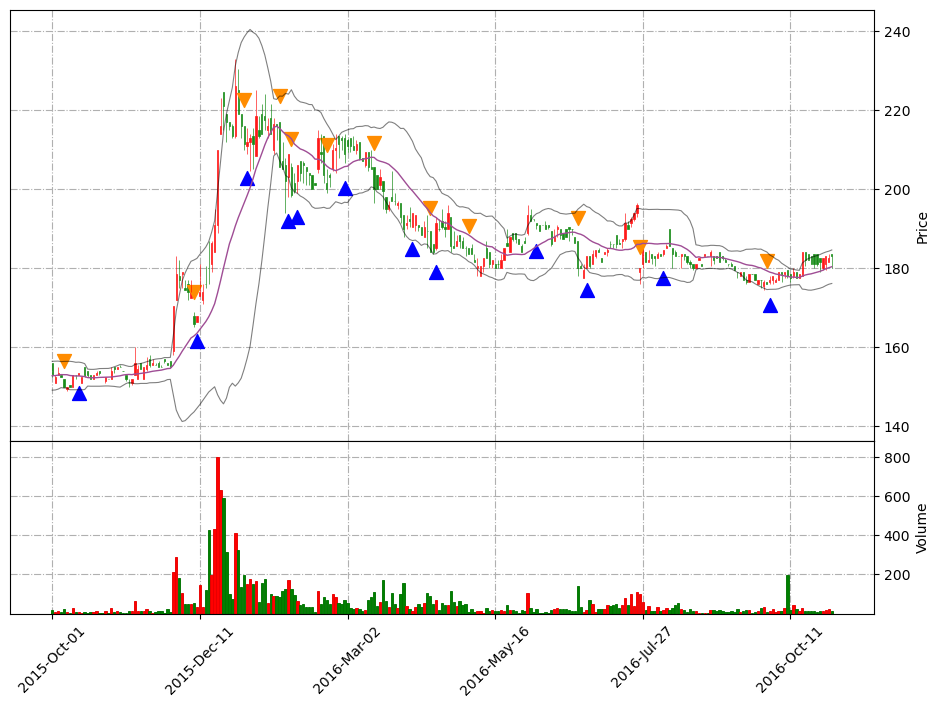

          Date  ticker_num  price  price(with_tax)          tax  \
0   2013-03-21        2124  235.0       235.334875   711.274500   
1   2013-03-28       -2124  222.0       221.017650  2086.511400   
2   2013-04-11        2309  203.0       203.289275   667.935975   
3   2013-04-16       -2309  187.5       186.670312  1915.748438   
4   2013-04-22        2266  190.0       190.270750   613.519500   
..         ...         ...    ...              ...          ...   
107 2021-01-07       -2138   77.8        77.455735   736.038570   
108 2021-01-08        2075   79.7        79.813573   235.662938   
109 2021-01-20       -2075   75.0        74.668125   688.640625   
110 2021-01-26        2063   75.0        75.106875   220.483125   
111 2021-03-26       -2063   75.0        74.668125   684.658125   

             spend        profit  profit_rate     profit_sum  profit_sum_rate  \
0   -499851.274500           NaN          NaN            NaN              NaN   
1    469441.488600 -30409.785900 

In [149]:
data = '2926_2013'
# 讀取資料
ticker = read_ticker_v2(data + '.csv')

# 標出交易策略多空點
ticker = bbands_ema_rule(ticker, bb_period=20, bb_stdnum=2, ma_period=5)

# 數據回測
ticker = back_track_v5(ticker, 500_000, stop_loss_percent=0.95) # 起始資金為五十萬

# 繪圖
dff = ticker.loc['2015-10':'2016-10', ]
plot_muti(dff, _title='', volume=True, buy_sell_point=True, 
    RSI=False, rsi_midline=False, rsi_bound=True, rsi_upper_bound=60, rsi_lower_bound=40, 
    KD=False, kd_bound=True, kd_upper_bound=60, kd_lower_bound=40, 
    MACD=False, BBands=True)

# 計算交易資訊
result = get_trade_info_v2(ticker)

print(result)

# 計算投資報酬率
profit = get_result(result)
print(profit)

result.to_csv(data + '_result.csv')

## kd + rsi

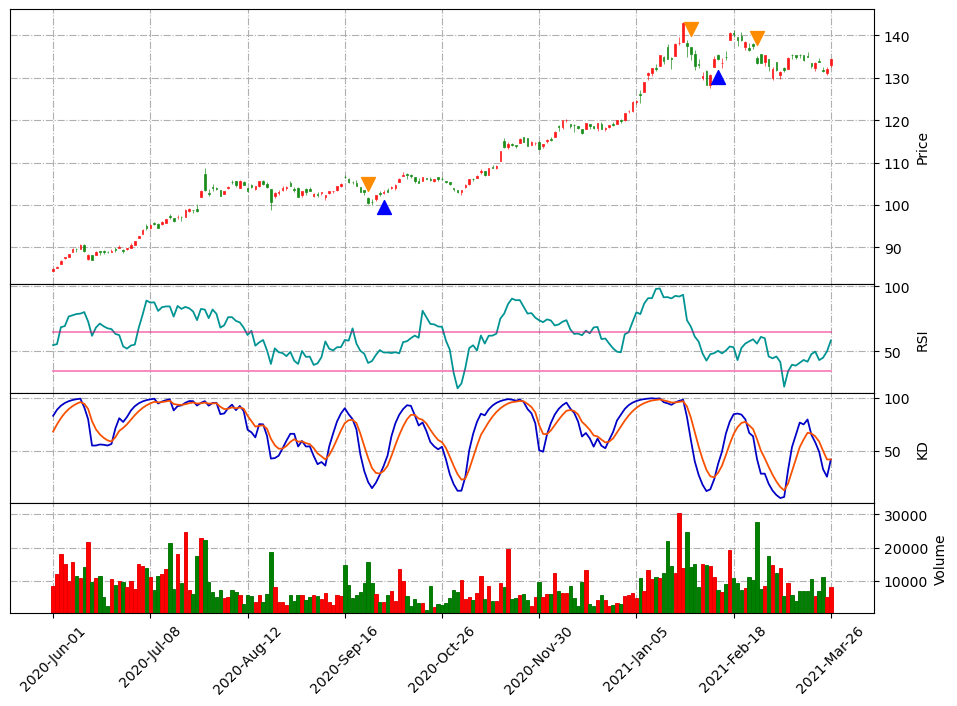

         Date  ticker_num   price  price(with_tax)          tax  \
0  2018-03-06        6077   82.15        82.267064   711.396409   
1  2018-04-23       -6077   79.95        79.596221  2149.913464   
2  2018-05-25        5902   81.85        81.966636   688.387147   
3  2018-10-08       -5902   83.00        82.632725  2167.657050   
4  2018-10-31        6279   77.55        77.660509   693.884441   
5  2018-12-10       -6279   74.45        74.120559  2068.561609   
6  2018-12-13        6091   76.30        76.408727   662.259203   
7  2019-01-04       -6091   72.20        71.880515  1945.983135   
8  2019-01-07        5913   73.95        74.055379   623.104549   
9  2019-05-16       -5913   79.05        78.700204  2068.345226   
10 2019-06-19        5754   80.75        80.865069   662.105587   
11 2019-08-15       -5754   79.40        79.048655  2021.639130   
12 2019-08-30        5549   81.85        81.966636   647.214551   
13 2020-01-30       -5549   92.15        91.742236  2262.68104

In [150]:
data = '0050_2018'
# 讀取資料
ticker = read_ticker_v2(data + '.csv')

# 標出交易策略多空點
ticker = kd_rsi_rule(ticker, rsi_buy_point=35, rsi_sell_point=65)

# 數據回測
ticker = back_track_v5(ticker, 500_000, stop_loss_percent=0.95) # 起始資金為五十萬

# 繪圖
dff = ticker.loc['2020-06':'2021-10', ]
plot_muti(dff, _title='', volume=True, buy_sell_point=True, 
    RSI=True, rsi_midline=False, rsi_bound=True, rsi_upper_bound=65, rsi_lower_bound=35, 
    KD=True, kd_bound=False, kd_upper_bound=85, kd_lower_bound=15, 
    MACD=False, BBands=False)

# 計算交易資訊
result = get_trade_info_v2(ticker)

print(result)

# 計算投資報酬率
profit = get_result(result)
print(profit)

result.to_csv(data + '_result.csv')

## MA + MACD

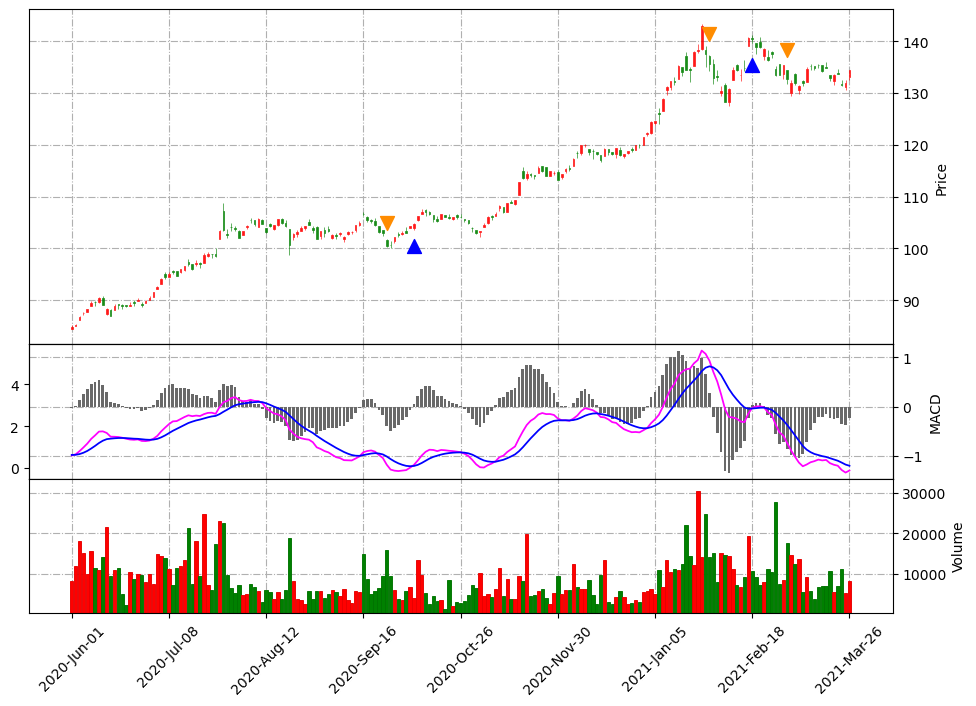

         Date  ticker_num   price  price(with_tax)          tax  \
0  2018-01-08        5936   84.10        84.219842   711.385080   
1  2018-02-05       -5936   83.60        83.230070  2195.904480   
2  2018-03-06        6006   82.15        82.267064   703.084883   
3  2018-04-23       -6006   79.95        79.596221  2124.795173   
4  2018-05-09        5934   80.45        80.564641   680.281178   
5  2018-10-08       -5934   83.00        82.632725  2179.409850   
6  2018-11-01        6245   78.40        78.511720   697.691400   
7  2018-12-10       -6245   74.45        74.120559  2057.360606   
8  2018-12-13        6058   76.30        76.408727   658.671195   
9  2019-01-04       -6058   72.20        71.880515  1935.440130   
10 2019-01-09        5798   75.00        75.106875   619.661250   
11 2019-05-16       -5798   79.05        78.700204  2028.118657   
12 2019-06-04        5838   78.05        78.161221   649.309657   
13 2019-08-15       -5838   79.40        79.048655  2051.15211

In [151]:
data = '0050_2018'
# 讀取資料
ticker = read_ticker_v2(data + '.csv')

# 標出交易策略多空點
ticker = macd_ma_rule(ticker, buy_point_name='buy_point', ma_period=5)

# 數據回測
ticker = back_track_v5(ticker, 500_000, stop_loss_percent=0.95) # 起始資金為五十萬

# 繪圖
dff = ticker.loc['2020-06':'2021-10', ]
plot_muti(dff, _title='', volume=True, buy_sell_point=True, 
    RSI=False, rsi_midline=True, rsi_bound=True, rsi_upper_bound=85, rsi_lower_bound=15, 
    KD=False, kd_bound=True, kd_upper_bound=85, kd_lower_bound=15, 
    MACD=True, BBands=False)

# 計算交易資訊
result = get_trade_info_v2(ticker)

print(result)

# 計算投資報酬率
profit = get_result(result)
print(profit)

result.to_csv(data + '_result.csv')

## 多支股票結果比較

## bband + ema

In [153]:
# 取得資料名稱串列
ticker_list = get_ticker_list()

# 回傳資料
res = []
# 總報酬
profit_sum = 0

for data in ticker_list:

    print(data)

    # 讀取資料
    ticker = read_ticker_v2(data)

    # 標出交易策略多空點
    ticker = bbands_ema_rule(ticker, bb_period=20, bb_stdnum=2, ma_period=5)

    # 數據回測
    ticker = back_track_v5(ticker, 500_000, stop_loss_percent=0.96)

    # 計算交易資訊
    result = get_trade_info_v2(ticker)

    # 計算投資報酬率
    profit = get_result(result)

    # 將該支股票之報酬率加總
    profit_sum += profit[len(profit) - 1]

    # 將當前資料加入新的一列
    res += [profit]
    
# 將陣列資料轉乘 dataframe
res = pd.DataFrame(res)

# 加入各列資料名稱 
res.set_axis(ticker_list, axis='rows', inplace=True)

# 加入各行數據名稱
res.set_axis(['Trades', 'Win', 'Loss', 'Win_Rate', 'Profit'], axis='columns', inplace=True)

# 印出總結果
print(res)

# 印出平均報酬率
print('平均報酬率 :', profit_sum / len(ticker_list))

0050_2018.csv
1304_2011.csv
1762_2010.csv
2065_2017.csv
2236_2015.csv
2330_2020.csv
2603_2020.csv
2748_2016.csv
2886_2019.csv
2926_2013.csv
               Trades  Win  Loss  Win_Rate       Profit
0050_2018.csv      14    6     8  0.428571    83.795825
1304_2011.csv     105   38    67  0.361905   -58.320526
1762_2010.csv     112   38    74  0.339286   -14.862008
2065_2017.csv      25    9    16  0.360000    53.800548
2236_2015.csv      89   31    58  0.348315   -39.652263
2330_2020.csv      25    9    16  0.360000    29.661810
2603_2020.csv      31   22     9  0.709677  1092.012945
2748_2016.csv      29   11    18  0.379310    14.366122
2886_2019.csv       3    2     1  0.666667    13.219851
2926_2013.csv      72   17    55  0.236111   -75.730378
平均報酬率 : 109.82919287708994


## kd + rsi

In [154]:
# 取得資料名稱串列
ticker_list = get_ticker_list()

# 回傳資料
res = []
# 總報酬
profit_sum = 0

for data in ticker_list:

    print(data)

    # 讀取資料
    ticker = read_ticker_v2(data)

    # 標出交易策略多空點
    ticker = kd_rsi_rule(ticker, rsi_buy_point=35, rsi_sell_point=65)

    # 數據回測
    ticker = back_track_v5(ticker, 500_000, stop_loss_percent=0.95)

    # 計算交易資訊
    result = get_trade_info_v2(ticker)

    # 計算投資報酬率
    profit = get_result(result)

    # 將該支股票之報酬率加總
    profit_sum += profit[len(profit) - 1]

    # 將當前資料加入新的一列
    res += [profit]
    
# 將陣列資料轉乘 dataframe
res = pd.DataFrame(res)

# 加入各列資料名稱 
res.set_axis(ticker_list, axis='rows', inplace=True)

# 加入各行數據名稱
res.set_axis(['Trades', 'Win', 'Loss', 'Win_Rate', 'Profit'], axis='columns', inplace=True)

# 印出總結果
print(res)

# 印出平均報酬率
print('平均報酬率 :', profit_sum / len(ticker_list))

0050_2018.csv
1304_2011.csv
1762_2010.csv
2065_2017.csv
2236_2015.csv
2330_2020.csv
2603_2020.csv
2748_2016.csv
2886_2019.csv
2926_2013.csv
               Trades  Win  Loss  Win_Rate      Profit
0050_2018.csv      10    5     5  0.500000   62.293785
1304_2011.csv      64   21    43  0.328125  -44.166623
1762_2010.csv      77   29    48  0.376623    0.283696
2065_2017.csv      20    8    12  0.400000   35.526795
2236_2015.csv      50   22    28  0.440000   26.687882
2330_2020.csv      14    6     8  0.428571   55.936857
2603_2020.csv      26   17     9  0.653846  514.986356
2748_2016.csv      22    7    15  0.318182   -8.341114
2886_2019.csv       0    0     0  0.000000    0.000000
2926_2013.csv      47    8    39  0.170213  -70.975017
平均報酬率 : 57.22326157097986


## ma + macd

In [155]:
# 取得資料名稱串列
ticker_list = get_ticker_list()

# 回傳資料
res = []
# 總報酬
profit_sum = 0

for data in ticker_list:

    print(data)

    # 讀取資料
    ticker = read_ticker_v2(data)

    # 標出交易策略多空點
    ticker = macd_ma_rule(ticker, buy_point_name='buy_point', ma_period=4)

    # 數據回測
    ticker = back_track_v5(ticker, 500_000, stop_loss_percent=0.95)

    # 計算交易資訊
    result = get_trade_info_v2(ticker)

    # 計算投資報酬率
    profit = get_result(result)

    # 將該支股票之報酬率加總
    profit_sum += profit[len(profit) - 1]

    # 將當前資料加入新的一列
    res += [profit]
    
# 將陣列資料轉乘 dataframe
res = pd.DataFrame(res)

# 加入各列資料名稱 
res.set_axis(ticker_list, axis='rows', inplace=True)

# 加入各行數據名稱
res.set_axis(['Trades', 'Win', 'Loss', 'Win_Rate', 'Profit'], axis='columns', inplace=True)

# 印出總結果
print(res)

# 印出平均報酬率
print('平均報酬率 :', profit_sum / len(ticker_list))

0050_2018.csv
1304_2011.csv
1762_2010.csv
2065_2017.csv
2236_2015.csv
2330_2020.csv
2603_2020.csv
2748_2016.csv
2886_2019.csv
2926_2013.csv
               Trades  Win  Loss  Win_Rate      Profit
0050_2018.csv      11    5     6  0.454545   64.125028
1304_2011.csv      69   22    47  0.318841  -20.144021
1762_2010.csv      81   32    49  0.395062   64.647422
2065_2017.csv      21   10    11  0.476190   38.512843
2236_2015.csv      54   21    33  0.388889    7.182621
2330_2020.csv      13    4     9  0.307692   39.050304
2603_2020.csv      25   17     8  0.680000  790.846346
2748_2016.csv      24    9    15  0.375000   23.849940
2886_2019.csv       2    2     0  1.000000   19.165758
2926_2013.csv      44   11    33  0.250000  -44.537802
平均報酬率 : 98.26984385970994


## 兩種回測方法比較

In [158]:
# ticker_list = get_ticker_list()

# res1 = []
# res2 = []
# # 總報酬
# profit_sum1 = 0
# profit_sum2 = 0

# for data in ticker_list:

#     print(data)

#     ticker = read_ticker_v2(data)

#     # # calculate the indicator
#     # ticker = MA(ticker, 5)
#     # ticker = MA(ticker, 10)
#     # ticker = MA(ticker, 5, 'Volume')
#     # ticker = EMA(ticker, 5)
#     # ticker = RSI(ticker, 13)
#     # ticker = KD(ticker, 6)
#     # ticker = MACD(ticker)
#     # # ticker = BBands(ticker, std_num=2)
#     # ticker = BBands(ticker)
#     # # ticker2 = BBands(ticker, period=12, std_num=1.8)

#     # # 刪除前幾筆存在部分指標不足的資料
#     # ticker = ticker.iloc[20:, ]

#     # 標出交易策略多空點
#     # ticker = kd_rsi_rule(ticker, rsi_buy_point=35, rsi_sell_point=65)
#     # ticker2 = kd_rsi_rule(ticker, rsi_buy_point=33, rsi_sell_point=68)
#     # ticker2 = kd_rsi_rule(ticker, rsi_buy_point=35, rsi_sell_point=65)
#     # ticker2 = bbands_ema_rsi_rule(ticker, rsi_buy_point=50, rsi_sell_point=70)
#     # ticker = ma_rule(ticker, period_f=4, period_s=8)
#     # ticker = kd_rsi_rule(ticker, rsi_buy_point=30, rsi_sell_point=70)
#     # ticker2 = kd_rsi_rule(ticker, rsi_buy_point=35, rsi_sell_point=60)
#     # ticker = macd_ma_rule(ticker, buy_point_name='buy_point', ma_period=4)
#     # ticker2 = macd_ma_rule(ticker, buy_point_name='buy_point', ma_period=4)
#     # ticker2 = macd_rule(ticker)
#     ticker1 = bbands_ema_rule(ticker, bb_period=20, bb_stdnum=2, ma_period=5)
#     ticker2 = bbands_ema_rule(ticker, bb_period=20, bb_stdnum=1.8, ma_period=5)

#     # 數據回測
#     ticker1 = back_track_v5(ticker1, 500_000, stop_loss_percent=0.95)
#     ticker2 = back_track_v5(ticker2, 500_000, stop_loss_percent=0.96)


#     # dff = ticker.loc['2020-01':'2020-12', ]
#     # plot_muti(dff, _title=data, volume=True, buy_sell_point=True, 
#     #     RSI=True, rsi_midline=False, rsi_bound=True, rsi_upper_bound=60, rsi_lower_bound=40, 
#     #     KD=True, kd_bound=False, kd_upper_bound=85, kd_lower_bound=15, 
#     #     MACD=True, BBands=True)

#     # 計算交易資訊
#     result1 = get_trade_info_v2(ticker1)
#     result2 = get_trade_info_v2(ticker2)

#     # 計算投資報酬率
#     profit1 = get_result(result1)
#     profit2 = get_result(result2)

#     # 將該支股票之報酬率加總
#     profit_sum1 += profit1[len(profit1) - 1]
#     profit_sum2 += profit2[len(profit2) - 1]

#     # 將當前資料加入新的一列
#     res1 += [profit1]
#     res2 += [profit2]
    
# # 將陣列資料轉乘 dataframe
# res1 = pd.DataFrame(res1)
# res2 = pd.DataFrame(res2)

# # 加入各列資料名稱 
# res1.set_axis(ticker_list, axis='rows', inplace=True)
# res2.set_axis(ticker_list, axis='rows', inplace=True)

# # 加入各行數據名稱
# res1.set_axis(['Trades', 'Win', 'Loss', 'Win_Rate', 'Profit'], axis='columns', inplace=True)
# res2.set_axis(['Trades', 'Win', 'Loss', 'Win_Rate', 'Profit'], axis='columns', inplace=True)

# print(res1)
# # 印出平均報酬率
# print('平均報酬率 :', profit_sum1 / len(ticker_list))
# print(res2)
# # 印出平均報酬率
# print('平均報酬率 :', profit_sum2 / len(ticker_list))

In [157]:
# ##網路上直接下載檔案的版本(測試用)

# # ticker_list = ['0050.tw', '1101.tw', '1605.tw', '2208.tw', '2301.tw', '2308.tw', '2317.tw']
# ticker_list = ['0050.tw','1101.tw','1102.tw','1216.tw','1301.tw','1303.tw','1326.tw','1402.tw','1476.tw','1605.tw','2002.tw','2105.tw',
#       '2207.tw','2301.tw','2303.tw','2308.tw','2317.tw','2324.tw','2330.tw','2354.tw','2357.tw',
#       '2382.tw','2395.tw','2408.tw','2409.tw','2412.tw','2474.tw','2801.tw','2881.tw','2882.tw',
#       '2883.tw','2884.tw','2885.tw','2886.tw','2887.tw','2890.tw','2892.tw','2912.tw','3008.tw',
#       '3045.tw','3481.tw','4904.tw','4938.tw','5880.tw','6505.tw','9904.tw','1227.tw','1319.tw',
#       '1440.tw','1477.tw','1504.tw','1536.tw','1589.tw','1590.tw','1605.tw','1707.tw','1717.tw','1722.tw',
#       '1723.tw','1789.tw','1802.tw','2015.tw','2049.tw','2059.tw','2101.tw','2103.tw','2106.tw','2201.tw',
#       '2231.tw','2313.tw','2327.tw','2345.tw','2347.tw','2352.tw','2353.tw','2355.tw','2360.tw','2362.tw',
#       '2376.tw','2377.tw','2379.tw','2383.tw','2385.tw','2392.tw','2449.tw','2451.tw','2498.tw','2501.tw',
#       '2542.tw','2603.tw','2609.tw','2610.tw','2615.tw','2618.tw','2707.tw','2809.tw','2812.tw','2823.tw',
#       '2834.tw','2845.tw','2849.tw','2903.tw','2915.tw','3034.tw','3037.tw','3044.tw','3189.tw','3231.tw',
#       '3673.tw','3702.tw','4958.tw','5522.tw','5871.tw','6176.tw','6239.tw','6269.tw','6285.tw','6414.tw',
#       '6415.tw','6456.tw','8150.tw','8454.tw','8464.tw','9907.tw','9910.tw','9914.tw','9917.tw','9921.tw',
#       '9933.tw','9938.tw','9945.tw']


# # 回傳資料
# res = []
# # 總報酬
# profit_sum = 0

# for data in ticker_list:

#     print(data)

#     ticker = y.download(data,start='2016-01-01',end='2021-12-31')
#     ticker = pd.DataFrame(ticker)
#     ticker = ticker.drop(['Adj Close'],axis=1)

#     # calculate the indicator
#     # ticker = MA(ticker, 5)
#     # ticker = MA(ticker, 5, 'Volume')
#     # ticker = EMA(ticker, 5)
#     # ticker = RSI(ticker, 13)
#     # ticker = KD(ticker, 6)
#     # ticker = MACD(ticker)
#     # # ticker = BBands(ticker)
#     # ticker = BBands(ticker, period=15, std_num=0.8)

#     # # 刪除前幾筆存在部分指標不足的資料
#     # ticker = ticker.iloc[20:, ]

#     # 標出交易策略多空點
#     # ticker = kd_rsi_rule(ticker, rsi_buy_point=30, rsi_sell_point=70)
#     # ticker = bbands_ema_rsi_rule(ticker, rsi_buy_point=50, rsi_sell_point=70)
#     # ticker = ma_rule(ticker, 4, 8)  52
#     # ticker = macd_ma_rule(ticker)
#     # ticker = bbands_ema_rsi_rule(ticker, bb_period=20, bb_stdnum=2, rsi_period=14, 
#     #         rsi_buy_point=60, rsi_sell_point=40, ma_period=5)
#     ticker = macd_ma_rule(ticker, buy_point_name='buy_point', ma_period=4)

#     # 數據回測
#     ticker = back_track_v5(ticker, 500_000, stop_loss_percent=0.96)

#     # # 繪圖
#     # dff = ticker.loc['2019-01':'2019-12', ]
#     # plot_muti(dff, _title=data, volume=True, buy_sell_point=True, 
#     #     RSI=True, rsi_midline=False, rsi_bound=True, rsi_upper_bound=60, rsi_lower_bound=40, 
#     #     KD=False, kd_bound=False, kd_upper_bound=85, kd_lower_bound=15, 
#     #     MACD=True, BBands=True)

#     # 計算交易資訊
#     result = get_trade_info_v2(ticker)

#     # 計算投資報酬率
#     profit = get_result(result)

#     # 將該支股票之報酬率加總
#     profit_sum += profit[len(profit) - 1]

#     # 將當前資料加入新的一列
#     res += [profit]
    
# # 將陣列資料轉乘 dataframe
# res = pd.DataFrame(res)

# # 加入各列資料名稱 
# res.set_axis(ticker_list, axis='rows', inplace=True)

# # 加入各行數據名稱
# res.set_axis(['Trades', 'Win', 'Loss', 'Win_Rate', 'Profit'], axis='columns', inplace=True)

# # 印出總結果
# print(res)

# res.to_csv('final_test')

# # 印出平均報酬率
# print('平均報酬率 :', profit_sum / len(ticker_list))